In [1]:
# Import modul - modul

from pathlib import Path
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import LambdaLR
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchinfo import summary
from sklearn.model_selection import KFold
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
from timeit import default_timer as timer
import os

import warnings 
warnings.filterwarnings('ignore')

print(f'Versi torch: {torch.__version__}')
print(f'Versi torchvision: {torchvision.__version__}')

Versi torch: 2.1.2
Versi torchvision: 0.16.2


In [2]:
# Cek device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# MENYIAPKAN DATA

In [3]:
data_path = Path('/kaggle/input/dtm1kv1')
image_path = data_path / 'dtm1k'
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Terdapat {len(dirnames)} directories dan {len(filenames)} citra di '{dirpath}'.")
    
walk_through_dir(image_path)

Terdapat 2 directories dan 0 citra di '/kaggle/input/dtm1kv1/dtm1k'.
Terdapat 4 directories dan 0 citra di '/kaggle/input/dtm1kv1/dtm1k/test'.
Terdapat 0 directories dan 20 citra di '/kaggle/input/dtm1kv1/dtm1k/test/yellow'.
Terdapat 0 directories dan 61 citra di '/kaggle/input/dtm1kv1/dtm1k/test/healthy'.
Terdapat 0 directories dan 60 citra di '/kaggle/input/dtm1kv1/dtm1k/test/redrot'.
Terdapat 0 directories dan 59 citra di '/kaggle/input/dtm1kv1/dtm1k/test/rust'.
Terdapat 4 directories dan 0 citra di '/kaggle/input/dtm1kv1/dtm1k/train'.
Terdapat 0 directories dan 80 citra di '/kaggle/input/dtm1kv1/dtm1k/train/yellow'.
Terdapat 0 directories dan 246 citra di '/kaggle/input/dtm1kv1/dtm1k/train/healthy'.
Terdapat 0 directories dan 242 citra di '/kaggle/input/dtm1kv1/dtm1k/train/redrot'.
Terdapat 0 directories dan 236 citra di '/kaggle/input/dtm1kv1/dtm1k/train/rust'.


In [4]:
# Inisiasi train dan test dir.
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/kaggle/input/dtm1kv1/dtm1k/train'),
 PosixPath('/kaggle/input/dtm1kv1/dtm1k/test'))

In [5]:
# Menyiapkan fungsi set_seed untuk reproduceability

def set_seed(seed):
    # Menyiapkan seed untuk random operasi python
    random.seed(seed)
    # Menyiapkan seed untuk random operasi torch untuk umum
    torch.manual_seed(seed)
    # Menyiapkan seed untuk random operasi torch untuk gpu NVIDIA
    torch.cuda.manual_seed(seed)
    # Menyiapkan seed untuk random operasi numpy
    np.random.seed(seed)

Direktori citra: /kaggle/input/dtm1kv1/dtm1k/train/healthy/DSCN0153.JPG
Class citra: healthy
Tinggi citra: 2592
Lebar citra: 4608


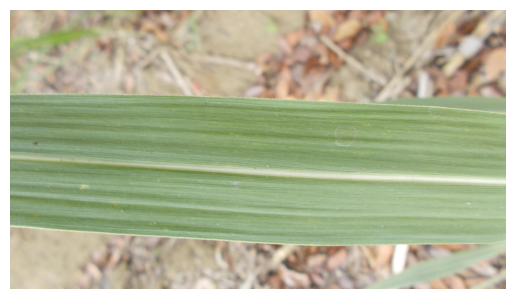

In [6]:
SEED = 7

# Inisiasi set_seed
set_seed(SEED)

# Cek dataset

data_path_list = list(image_path.glob('*/*/*.JPG'))
rand_image = random.choice(data_path_list)
image_class = rand_image.parent.stem
img = Image.open(rand_image)

print(f'Direktori citra: {rand_image}')
print(f'Class citra: {image_class}')
print(f'Tinggi citra: {img.height}')
print(f'Lebar citra: {img.width}')
plt.imshow(img)
plt.axis('off')
plt.show()

# MENYIAPKAN MODEL SWIN TRANSFORMER

In [7]:
'''
Menyiapkan pre-trained weight untuk fine-tuning dan
pre-trained transform input dari Swin Transformer Base
'''

weights = torchvision.models.Swin_T_Weights.IMAGENET1K_V1
pre_trained_transforms = weights.transforms()

In [8]:
# Menyiapkan variabel augmentasi

augmented_transform = v2.Compose([
    pre_trained_transforms,
    v2.RandAugment(num_ops = 2, magnitude = 9)
])

normal_transform = v2.Compose([
    pre_trained_transforms
])

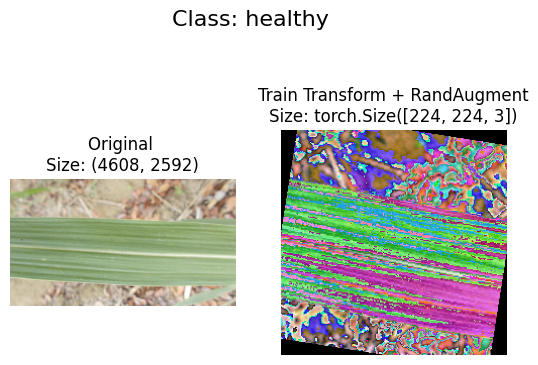

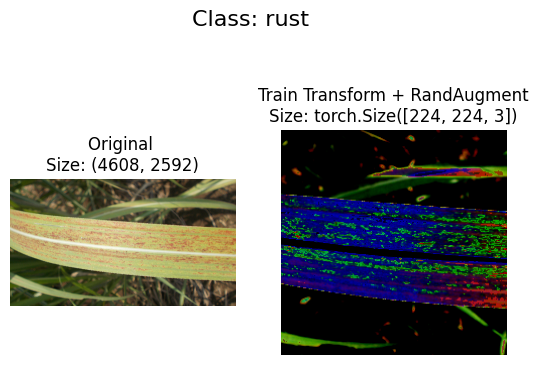

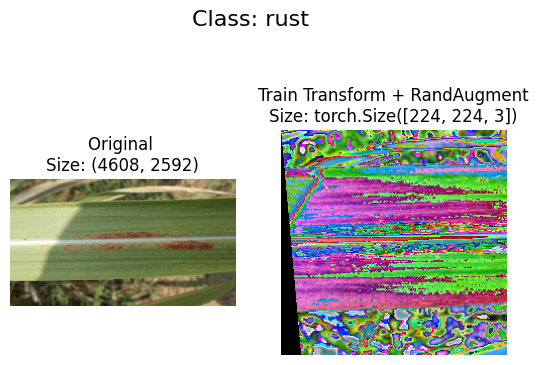

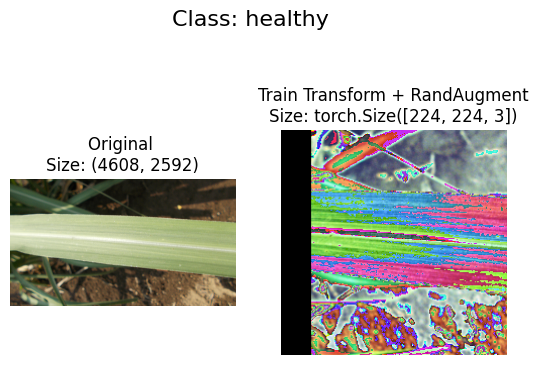

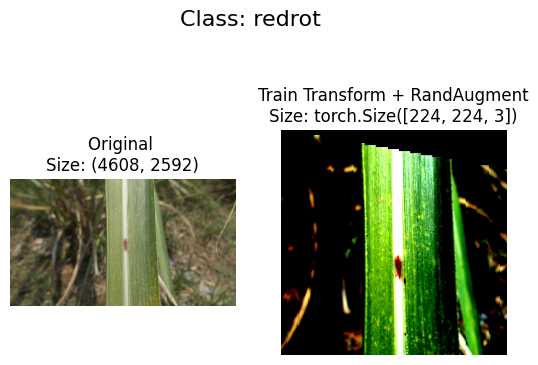

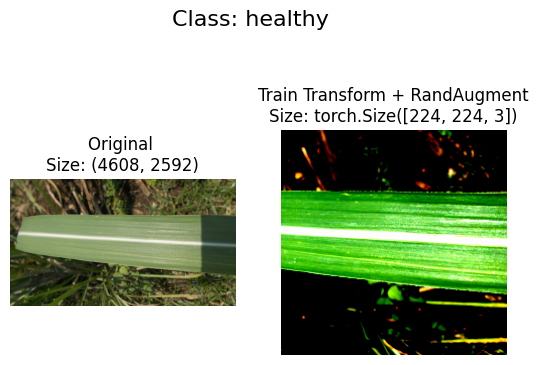

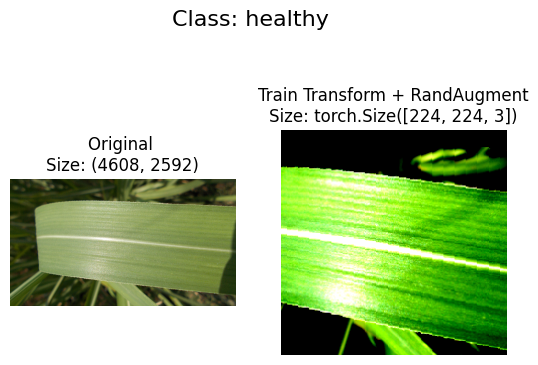

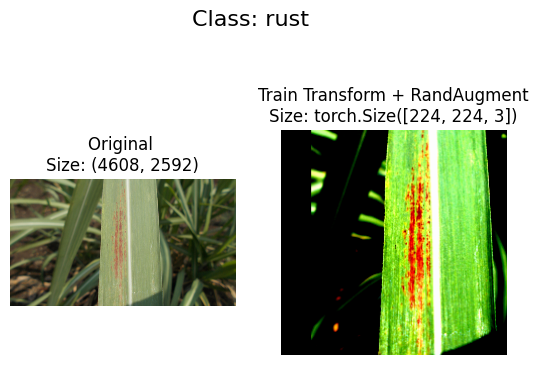

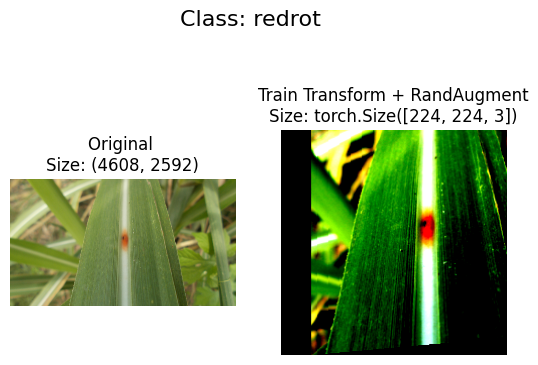

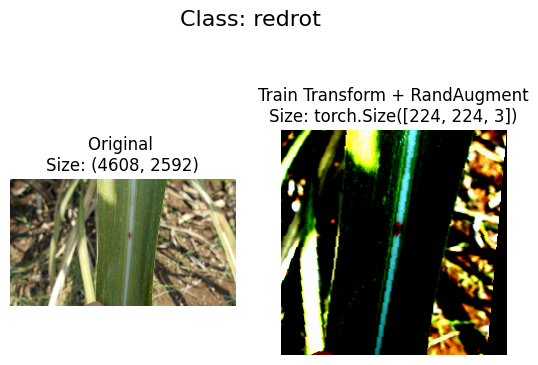

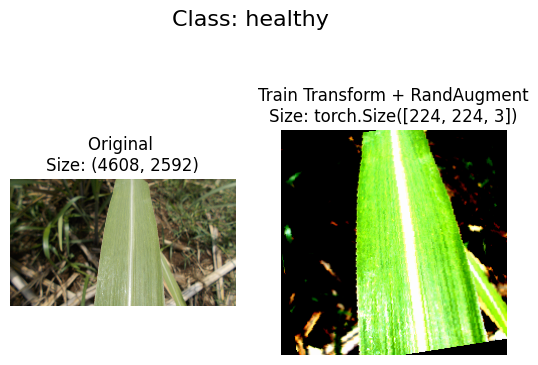

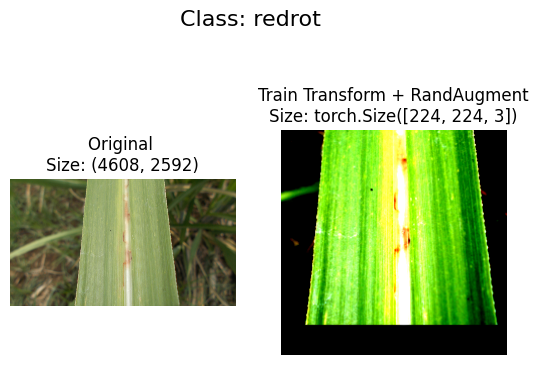

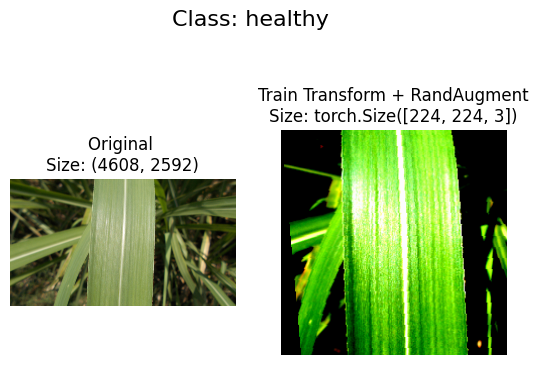

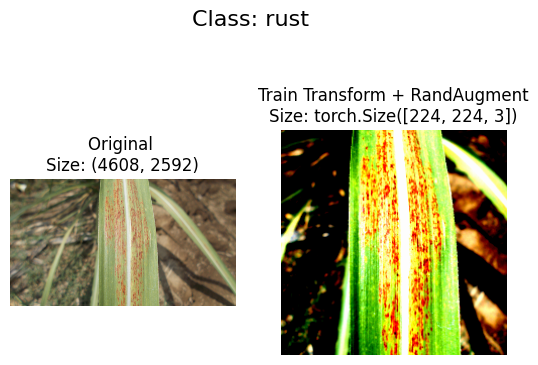

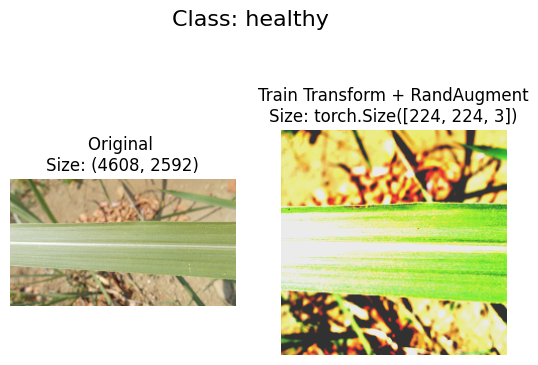

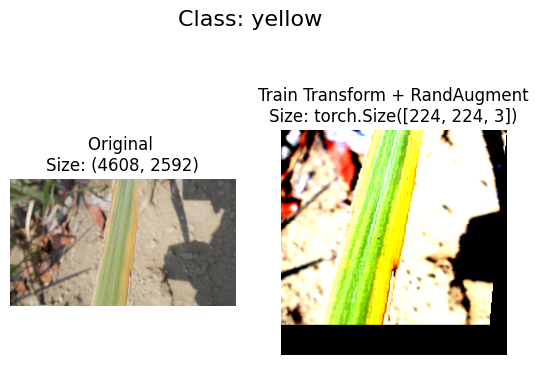

In [9]:
# Cek augmentasi

def plot_transformed_images(image_paths, train_transform, n = 3, seed = SEED):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    # Inisiasi set_seed
    set_seed(SEED)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            train_transformed_image = train_transform(f).permute(1, 2, 0) 
            ax[1].imshow(train_transformed_image) 
            ax[1].set_title(f'Train Transform + RandAugment\nSize: {train_transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(data_path_list,  
                        train_transform = augmented_transform,
                        n = 16)

In [10]:
# Membuat datasets dengan ImageFolder

# Inisiasi set_seed
set_seed(SEED)

TRAIN_DATA = datasets.ImageFolder(root = train_dir, # folder target untuk citra
                                  transform = normal_transform, # transform pada semua citra
                                  target_transform = None) # transform pada citra dengan label tertentu (jika perlu)

AUGMENTED_DATA = datasets.ImageFolder(root = train_dir,
                                      transform = augmented_transform,
                                      target_transform = None)

TEST_DATA = datasets.ImageFolder(root = test_dir, 
                                transform = normal_transform,
                                target_transform = None)

# Menggabungkan datasets original dan augmentasi
AUGOR_DATA = ConcatDataset([TRAIN_DATA, AUGMENTED_DATA])

print(f'Train data:\n{TRAIN_DATA}\n\nAugmented data:\n{AUGMENTED_DATA}\nTest data:\n{TEST_DATA}\nAugmented + Original data:\n{AUGOR_DATA}\nJumlah Data: {len(AUGOR_DATA)}')

Train data:
Dataset ImageFolder
    Number of datapoints: 804
    Root location: /kaggle/input/dtm1kv1/dtm1k/train
    StandardTransform
Transform: Compose(
                 ImageClassification(
                 crop_size=[224]
                 resize_size=[232]
                 mean=[0.485, 0.456, 0.406]
                 std=[0.229, 0.224, 0.225]
                 interpolation=InterpolationMode.BICUBIC
             )
           )

Augmented data:
Dataset ImageFolder
    Number of datapoints: 804
    Root location: /kaggle/input/dtm1kv1/dtm1k/train
    StandardTransform
Transform: Compose(
                 ImageClassification(
                 crop_size=[224]
                 resize_size=[232]
                 mean=[0.485, 0.456, 0.406]
                 std=[0.229, 0.224, 0.225]
                 interpolation=InterpolationMode.BICUBIC
             )
                 RandAugment(interpolation=InterpolationMode.NEAREST, num_ops=2, magnitude=9, num_magnitude_bins=31)
           )
Test dat

In [11]:
# Membuat train dan test data loader

# Config dataloader
BATCH_SIZE = 16
NUM_WORKERS = 4

# Inisiasi set_seed
set_seed(SEED)

train_dataloader = DataLoader(dataset = AUGOR_DATA, 
                              batch_size = BATCH_SIZE, # seberapa banyak sampel per-batch?
                              num_workers = NUM_WORKERS, # seberapa banyak subproses untuk memuat data? (semakin tinggi semakin banyak)
                              shuffle = True) # acak data?

test_dataloader = DataLoader(dataset = TEST_DATA, 
                             batch_size = BATCH_SIZE, 
                             num_workers = NUM_WORKERS, 
                             shuffle = False) # tidak perlu untuk test dataset

print(train_dataloader)
print(test_dataloader)
class_names = TRAIN_DATA.classes
CLASS_COUNT = len(TRAIN_DATA.classes)
print(f'\nNama - nama kelas: {class_names}')
print(f'Jumlah total kelas: {CLASS_COUNT}')


Nama - nama kelas: ['healthy', 'redrot', 'rust', 'yellow']
Jumlah total kelas: 4


In [12]:
# Cek shape dan label

# Inisiasi set_seed
set_seed(SEED)

img, label = next(iter(train_dataloader))

print(f'Shape citra: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Shape label (jumlah label per-batch): {label.shape}')

Shape citra: torch.Size([16, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Shape label (jumlah label per-batch): torch.Size([16])


In [13]:
# Inisiasi model Swin Transformer

model = torchvision.models.swin_t(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 84.3MB/s]


In [14]:
# Cek model awal

summary(model = model,
        input_size = (BATCH_SIZE, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [16, 3, 224, 224]    [16, 1000]           --                   True
├─Sequential (features)                                 [16, 3, 224, 224]    [16, 7, 7, 768]      --                   True
│    └─Sequential (0)                                   [16, 3, 224, 224]    [16, 56, 56, 96]     --                   True
│    │    └─Conv2d (0)                                  [16, 3, 224, 224]    [16, 96, 56, 56]     4,704                True
│    │    └─Permute (1)                                 [16, 96, 56, 56]     [16, 56, 56, 96]     --                   --
│    │    └─LayerNorm (2)                               [16, 56, 56, 96]     [16, 56, 56, 96]     192                  True
│    └─Sequential (1)                                   [16, 56, 56, 96]     [16, 56, 56, 96]     --                   True
│    

In [15]:
# Buat model agar bisa transfer-learning dari weights yang telah diimport
for param in model.features.parameters():
    param.requires_grad = False

# Modifikasi head model sesuai dengan output kelas datasets
model.head = torch.nn.Linear(in_features = 768,
                    out_features = CLASS_COUNT,
                    bias = True).to(device)

# Cek ulang model yang telah dimodifikasi
summary(model = model,
        input_size = (BATCH_SIZE, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [16, 3, 224, 224]    [16, 4]              --                   Partial
├─Sequential (features)                                 [16, 3, 224, 224]    [16, 7, 7, 768]      --                   False
│    └─Sequential (0)                                   [16, 3, 224, 224]    [16, 56, 56, 96]     --                   False
│    │    └─Conv2d (0)                                  [16, 3, 224, 224]    [16, 96, 56, 56]     (4,704)              False
│    │    └─Permute (1)                                 [16, 96, 56, 56]     [16, 56, 56, 96]     --                   --
│    │    └─LayerNorm (2)                               [16, 56, 56, 96]     [16, 56, 56, 96]     (192)                False
│    └─Sequential (1)                                   [16, 56, 56, 96]     [16, 56, 56, 96]     --                   Fal

# PROSES TRAINING

In [16]:
# Inisiasi config
total_epochs = 50
warmup_epochs = 5
initial_lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = initial_lr, weight_decay = 0.05)

# Scheduler learning rate dengan cosine decay dan linear warm-up
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs  # Linear warm-up
    else:
        # Cosine decay setelah warm-up, pastikan input berupa Tensor
        cosine_decay = 0.5 * (1 + torch.cos(torch.tensor((epoch - warmup_epochs) * torch.pi / (total_epochs - warmup_epochs))))
        return cosine_decay.item()  # Kembalikan sebagai float untuk scheduler
    
# Scheduler setup
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [17]:
# Membuat fungsi fit train

# Inisiasi set_seed
set_seed(SEED)

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # Grad clipping
        nn.utils.clip_grad_norm_(parameters = model.parameters(), max_norm = 5.0)
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # Scheduler step
    scheduler.step()
    
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Membuat variabel best model
    best_test_acc = 0
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer, scheduler = scheduler,
                                          device = device)
        test_loss, test_acc = test_step(model = model,
          dataloader = test_dataloader,
          loss_fn = loss_fn,
          device = device)
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        if best_test_acc <= test_acc:
            best_test_acc = test_acc
            BEST_PATH = Path('../working')
            BEST_MODEL_NAME = f'Best_Swin_DaunTebu_RandAugment_Kaggle.pth'
            BEST_SAVE_PATH = BEST_PATH/BEST_MODEL_NAME
            torch.save(obj = model.state_dict(),f = BEST_SAVE_PATH)
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

In [18]:
# Inisiasi set_seed
set_seed(SEED)

# Start timer
start_time = timer()

# Setup training and save the results
hasil = train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer, scheduler = scheduler,
                       loss_fn = loss_fn,
                       epochs = total_epochs,
                       device = device)

# End timer dan lihat berapa detik waktu train
end_time = timer()
print(f'Total waktu train: {end_time-start_time:.3f} detik')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4233 | train_acc: 0.2531 | test_loss: 1.4152 | test_acc: 0.2788
Epoch: 2 | train_loss: 1.1779 | train_acc: 0.5136 | test_loss: 0.9856 | test_acc: 0.7452
Epoch: 3 | train_loss: 0.8812 | train_acc: 0.7339 | test_loss: 0.5958 | test_acc: 0.9183
Epoch: 4 | train_loss: 0.6449 | train_acc: 0.8187 | test_loss: 0.4009 | test_acc: 0.9423
Epoch: 5 | train_loss: 0.5191 | train_acc: 0.8416 | test_loss: 0.2843 | test_acc: 0.9567
Epoch: 6 | train_loss: 0.4388 | train_acc: 0.8756 | test_loss: 0.2411 | test_acc: 0.9567
Epoch: 7 | train_loss: 0.3779 | train_acc: 0.8855 | test_loss: 0.2003 | test_acc: 0.9519
Epoch: 8 | train_loss: 0.3734 | train_acc: 0.8837 | test_loss: 0.1702 | test_acc: 0.9567
Epoch: 9 | train_loss: 0.3355 | train_acc: 0.8874 | test_loss: 0.1475 | test_acc: 0.9663
Epoch: 10 | train_loss: 0.3045 | train_acc: 0.9053 | test_loss: 0.1283 | test_acc: 0.9663
Epoch: 11 | train_loss: 0.3057 | train_acc: 0.9022 | test_loss: 0.1397 | test_acc: 0.9471
Epoch: 12 | train_l

In [19]:
PATH = Path('../working')
MODEL_NAME = 'Swin_DaunTebu_RandAugment_Kaggle.pth'

SAVE_PATH = PATH/MODEL_NAME

print(f'Menyimpan model ke: {SAVE_PATH}')
torch.save(obj = model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f = SAVE_PATH)

Menyimpan model ke: ../working/Swin_DaunTebu_RandAugment_Kaggle.pth


# EVALUASI MODEL

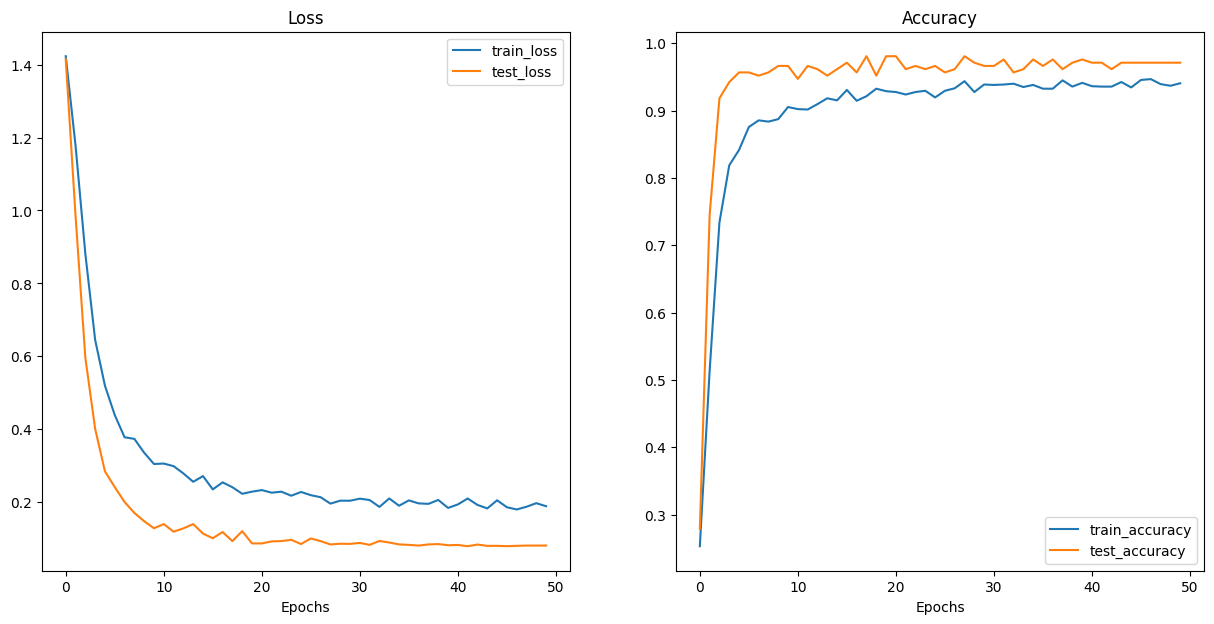

In [20]:
def plot_grafik_loss(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    
# Inisiasi set_seed
set_seed(SEED)
plot_grafik_loss(hasil)

In [21]:
best_model = torchvision.models.swin_t(weights = weights).to(device)
best_model.head = torch.nn.Linear(in_features = 768,
                    out_features = CLASS_COUNT,
                    bias = True).to(device)
best_model.load_state_dict(torch.load('../working/Best_Swin_DaunTebu_RandAugment_Kaggle.pth'))

<All keys matched successfully>

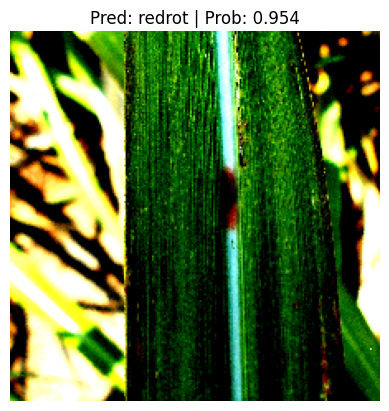

In [22]:
custom_img_path = Path('/kaggle/input/dtm1kv1/dtm1k/test/redrot/DSCN0901.JPG')

def pred_gambar(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    """Makes a prediction on a target image and plots the image with its prediction."""
    '''
    ARGS
    pred_gambar(model = model,
                    image_path = path,
                    class_names=class_names,
                    transform = None,
                    device = device)
    '''
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    else: 
        title = f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    plt.title(title)
    plt.axis(False);

# Inisiasi set_seed
set_seed(SEED)

pred_gambar(model = best_model,
                image_path = custom_img_path,
                class_names = class_names,
                transform = normal_transform,
                device = device)

In [23]:
def get_pred(model, test_dataloader, device, class_names):

    from tqdm.auto import tqdm

    # Make predictions on the entire test dataset
    test_preds = []
    model.eval()
    with torch.inference_mode():
        # Loop through the batches in the test dataloader
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            # Pass the data through the model
            test_logits = model(X)

            # Convert the pred logits to pred probs
            pred_probs = torch.softmax(test_logits, dim=1)

            # Convert the pred probs into pred labels
            pred_labels = torch.argmax(pred_probs, dim=1)

            # Add the pred labels to test preds list
            test_preds.append(pred_labels)

    # Concatenate the test preds and put them on the CPU
    test_preds = torch.cat(test_preds).cpu()
    test_truth = torch.cat([y for X, y in test_dataloader])
    return test_truth, test_preds

# Inisiasi set_seed
set_seed(SEED)

y_true, y_pred = get_pred(model = best_model,
                                     test_dataloader = test_dataloader,
                                     device = device,
                                     class_names = class_names)

  0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
def confusion_matrix(test_truth, test_preds, class_names):
    
    # Setup confusion matrix instance
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=test_preds,
                            target=test_truth)

    # Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
        class_names=class_names,
        figsize=(10, 7)
    )
    
def classification_reports(test_truth, test_preds, class_names = None):
    print(f'\nLaporan Klasifikasi Model\n{classification_report(y_true = test_truth, y_pred = test_preds, target_names = class_names, digits = 4)}')

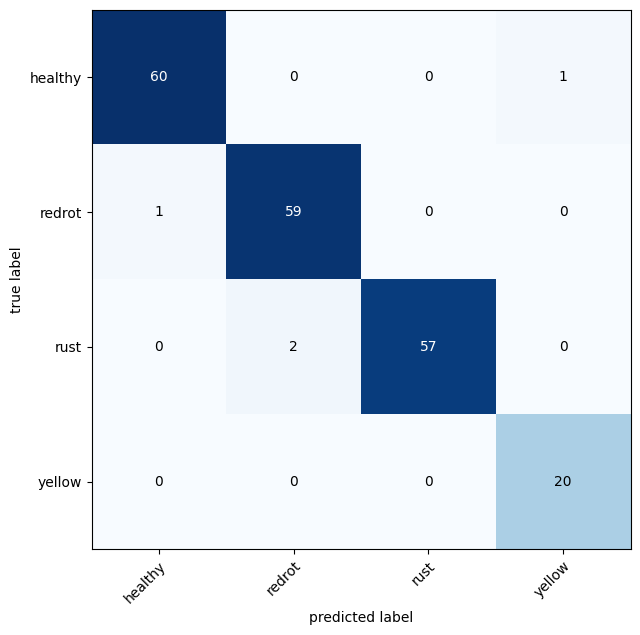

In [25]:
confusion_matrix(y_true, y_pred, class_names = class_names)

In [26]:
classification_reports(y_true, y_pred, class_names = class_names)


Laporan Klasifikasi Model
              precision    recall  f1-score   support

     healthy     0.9836    0.9836    0.9836        61
      redrot     0.9672    0.9833    0.9752        60
        rust     1.0000    0.9661    0.9828        59
      yellow     0.9524    1.0000    0.9756        20

    accuracy                         0.9800       200
   macro avg     0.9758    0.9833    0.9793       200
weighted avg     0.9804    0.9800    0.9800       200

